## Assignment 1 Model Fitting with Maximum Likelihood 
* The purpose of this assignment is to learn how to write a log likelihood function, fit models to data with maximum likelihood and to select among models using AIC and a validation set.  
* Along the way, we'll learn a bit about decision making models and response time data.  

### Due: Sunday 10/19

In [34]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
def shiftedwald(params, x):
    '''
    params: is a list or numpy array containing two parameters
    x: are the data
    '''
 
    gamma = params[0] #drift rate
    alpha = params[1] #boundary separation
    theta = params[2] #shift or nondecision time 
    x = x-theta
    x = np.maximum(x, 1e-6)
    z = alpha/np.sqrt(2*np.pi*(x**3))
    w = ((np.abs(alpha-gamma*x))**2)/(2*x)
    f = z*np.exp(-w)
    return f  #probs

### A Perceptual Discrimination Task to Study Decision Making

This is actual data from my lab, which was published here:

Nunez, M. D., Vandekerckhove, J., & Srinivasan, R. (2017). How attention influences perceptual decision making: Single-trial EEG correlates of drift-diffusion model parameters. Journal of Mathematical Psychology, 76(Part B), 117–130. https://doi.org/10.1016/j.jmp.2016.03.003

Human subject were asked to discriminate the spatial frequency of Gabor patches (as shown below), embeded in noise.  Task difficulty was controlled by the difficulty of the discrimination.  Two Gabors with more similar spatial frequencies are harder to discriminate, especially when noise is added.  In each of 34 participant, The experiment was performed in Easy, Medium, and Hard blocks each consisting of with decreasing differences between the Gabor spatial frequencies.  

![](spatialfrequency.png)

The datafile ReactionTimeData.csv is for use in this homework. You can load it into your notebook using pandas. There are 3 variables in the file: 

* Subject - indicates a numeric subject id 
* Experimental Condition - Easy, Medium, Hard 
* Correct - 1 if correct 0 if incorrect 
* ResponseTime  - time from stimulus presentation to decision in units of millisecond 

#### Problem 1 Explore and Visualize the Data.  I recommend using this exercise to learn about seaborn. 
a. make a histogram of Response Time for an individual subject, showing all 3 difficulty conditions in a single graph.
 
 

   Unnamed: 0  Subject Condition  Correct  ResponseTime
0           0        1    Medium        1           756
1           1        1      Hard        1           756
2           2        1      Easy        1           757
3           3        1      Easy        1           758
4           4        1    Medium        0           759


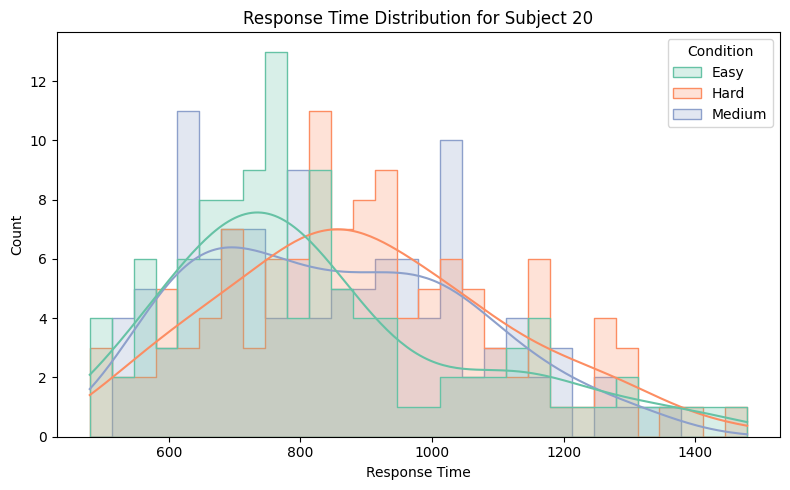

In [18]:
data = pd.read_csv("ResponseTimeData.csv")
print(data.head())
subject_id = 20
subject_data = data[data["Subject"] == subject_id]

plt.figure(figsize=(8,5))
sns.histplot(data=subject_data, x = "ResponseTime", hue = "Condition", bins = 30, kde = True, element = "step", palette = "Set2")

plt.title(f"Response Time Distribution for Subject {subject_id}")
plt.xlabel("Response Time")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


b. make a bar graph showing the accuracy (proportion or percentage correct) in each condition.  

Condition
Easy      0.884263
Hard      0.671462
Medium    0.804236
Name: Correct, dtype: float64


TypeError: 'str' object is not callable

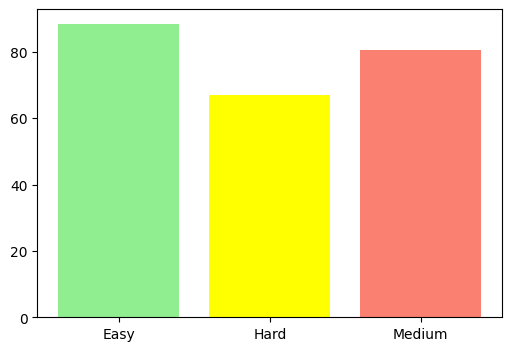

In [ ]:
data = pd.read_csv("ResponseTimeData.csv")
accuracy = data.groupby("Condition")["Correct"].mean()

print(accuracy)
#var 
plt.figure(figsize=(6,4))
plt.bar(accuracy.index, accuracy.values * 100, hue_order
        color = ['lightgreen', 'yellow', 'salmon'])

plt.title("Accuracy by Condition")
plt.xlabel("Experimental Condition")
plt.ylabel("Accuracy %")

c. Make a boxplot that shows the distributions of each condition, with correct and incorrect trials separated. 

   Unnamed: 0  Subject Condition  Correct  ResponseTime
0           0        1    Medium        1           756
1           1        1      Hard        1           756
2           2        1      Easy        1           757
3           3        1      Easy        1           758
4           4        1    Medium        0           759


<Axes: xlabel='Condition', ylabel='ResponseTime'>

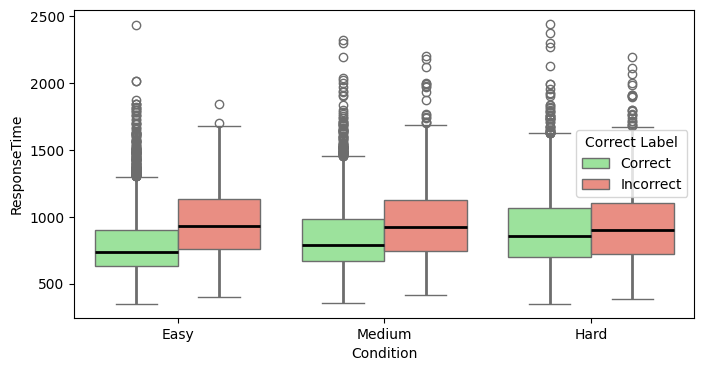

In [ ]:
data = pd.read_csv("ResponseTimeData.csv")
print(data.head())
data['Correct Label'] = data['Correct'].map({1: 'Correct', 0: 'Incorrect'})

cond_order = ['Easy', 'Medium', 'Hard']
data['Condition'] = pd.Categorical(data['Condition'], categories=cond_order, ordered=True)

plt.figure(figsize=(8,4))
sns.boxplot(data = data, x = 'Condition', y = 'ResponseTime', hue = 'Correct Label', 
            palette = {'Correct': 'lightgreen', 'Incorrect': 'salmon'}, showcaps = True,
            boxprops = {'linewidth': 1}, whiskerprops = {'linewidth': 2}, 
            medianprops = {'linewidth': 2, 'color': 'black'})

#dodge = True, alpha = 0.3, size = 3, jitter = 0.25, palette = ['Correct': 'lightgreen', 'Incorrect': 'salmon'])

d. Calculate the mean reaction time for each subject in each condition.  Make a histogram that shows the distribution of mean RT across subjects,showing all 3 conditions in a single graph. 

102
Subject  Condition
1        Easy         1129.513514
         Hard         1125.193548
         Medium       1044.485294
2        Easy          756.562500
         Hard          859.818182
Name: ResponseTime, dtype: float64
(102, 3)


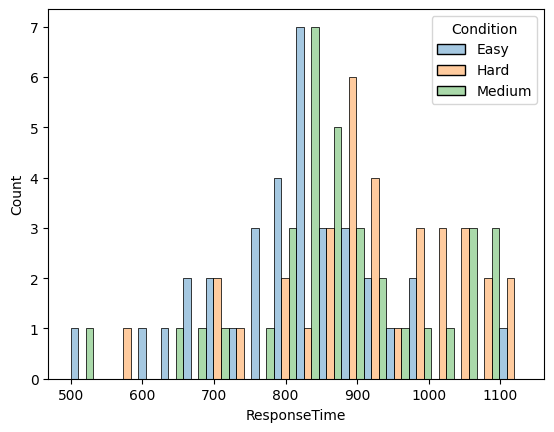

In [73]:
data = pd.read_csv("ResponseTimeData.csv")
#print(data.head())
groups = data.groupby(["Subject", "Condition"])
print(groups.ngroups)
groups.get_group((1, "Easy"))


mean_rt = groups["ResponseTime"].mean()
print(mean_rt.head())

mean_rt = mean_rt.reset_index()
print(mean_rt.shape)

sns.histplot(data = mean_rt, x = "ResponseTime", hue = "Condition", element = "bars", multiple= "dodge", bins = 20, alpha = 0.4)
plt.title = ("Distribution of Mean Response Time across Subjects")

In class we discussed how different distributions might be used to model Response Time data in decision making tasks.  In particular, the shifted Wald distribution is a distribution that captures aspects of the processes that give rise to Response Time.  

The shifted Wald distribution is a 1-boundary model. And, for simplicity, we will only consider correct trials.  



In [185]:
def shiftedwald(params, x):
    '''
    params: is a list or numpy array containing two parameters
    x: are the data
    '''
 
    gamma = params[0] #drift rate
    alpha = params[1] #boundary separation
    theta = params[2] #shift or nondecision time 
    x = x-theta
    x = np.maximum(x, 1e-6)
    z = alpha/np.sqrt(2*np.pi*(x**3))
    w = (((alpha-gamma*x))**2)/(2*x)
    f = z*np.exp(-w)
    return f  #probs

### Problem 2 
Use the shifted Wald distribution defined above.  Write a function which computes the negative log likelihood of the shifted Wald distribution.  Assume that the data to be analyzed is in a variable called data. 

The function should return negative log likelihood 

In [186]:
def negloglikeWald(params, data):
    ''' written with params containing gamma, alpha, theta in that order.  Assumes data is in the variable data'''
    f = shiftedwald(params, data)
    f = np.maximum(f, 1e-10)
    logf = np.log(f)
    log_likelihood = np.sum(logf)
    negloglike = -log_likelihood
    return negloglike 

### Problem 3 

Using the function the negative log-likelihood that you developed in problem 1, fit the shifted Wald distribution to the data for ALL the subjects in ReactionTimeData.csv.  

You should consider two models: 
Model A: All of the data comes from a single distribution. 
Model B: The data in each condition (Easy, Medium, Hard) comes from a separate distribution. 

When providing bounds to the fitting process, keep in mind that the only constraints on the parameters of this model is that they have to be positive.  To specify an upper bound of infinity, use `np.inf`

If you run into problems with your computer taking too long, reduce the amount of data, even do just 1 or a few subjects.

Make a plot or table or something to show me (make it pretty!) how the resulting parameter fits turned out.  

In [189]:
df = pd.read_csv("ResponseTimeData.csv")
from scipy.optimize import minimize

RT = df['ResponseTime']
correct = df['Correct']
data = RT[(correct == 1)].values

paramfit = {}
bnds = ((0.01, np.inf), (0.01, np.inf), (0.01, np.min(data)-1))

#A
data = df.loc[df['Correct'] == 1, 'ResponseTime'].values
paramfit['All'] = minimize(negloglikeWald, [0.1,100,200], args=(data,), bounds = bnds)

#B
data = df[(df['Correct'] == 1) & (df['Condition'] == 'Easy')]['ResponseTime'].values
paramfit['Easy'] = minimize(negloglikeWald, [0.1,100,200], args=(data,), bounds = bnds)

data = df[(df['Correct'] == 1) & (df['Condition'] == 'Medium')]['ResponseTime'].values
paramfit['Medium'] = minimize(negloglikeWald, [0.1,100,200], args=(data,), bounds = bnds)

data = df[(df['Correct'] == 1) & (df['Condition'] == 'Hard')]['ResponseTime'].values
paramfit['Hard'] = minimize(negloglikeWald, [0.1,100,200], args=(data,), bounds = bnds)



In [192]:
fit_table = pd.DataFrame({'Condition': list(paramfit.keys()), 
    'Gamma': [paramfit[k].x[0] for k in paramfit],
    'Alpha': [paramfit[k].x[1] for k in paramfit],
    'Theta': [paramfit[k].x[2] for k in paramfit],
    'NegLogLike': [paramfit[k].fun for k in paramfit]
})

print(fit_table)

  Condition     Gamma      Alpha       Theta    NegLogLike
0       All  0.099163  64.931741  190.483069  62486.859282
1      Easy  0.107167  64.676046  189.931975  22795.366153
2    Medium  0.100307  66.011345  190.610012  21354.089220
3      Hard  0.094482  67.691481  191.756221  18186.307067


### Problem 4 

Use AIC to evaluate which model you should prefer.  Do the data come from 1 distribution or from three different distributions?  

In [193]:
aic_A = 2 * 3 + 2 * paramfit['All'].fun
aic_B = 2 * 9 + 2 * (paramfit['Easy'].fun + paramfit['Medium'].fun + paramfit['Hard'].fun)

print(f'Model A: {aic_A:.1f}')
print(f'Model B: {aic_B:.1f}')


Model A: 124979.7
Model B: 124689.5


Model B seems to be better becuase it has a lower AIC value. This suggests that the 3 condition model fits the data better. 
This might mean that response times differ across difficulty levels.

### Problem 5 

The two models given above are not the only models we could propose. The power of likelihood and modeling (as opposed to statistical testing) is if we can be very specific about our hypothesis.    

The original idea of this experiment was to manipulate drift rate in order to find brain activity related to speed of information processing. 
So, our hypothesis was that non-decision time, and boundary would be the same for all conditions, and only the drift rate would vary.  

Write a function for negative log likelihood for a model that keeps boundary (alpha) and non-decision time (theta) the same for all 3 conditions, but allows drift rate (gamma) to vary between conditions. 

In this model there are now 5 parameters - gamma_easy, gamma_medium, gamma_hard, alpha, theta. 
The likelihood should be evaluated using the correct gamma for each condition, and using the sama alpha and theta for all condition.  

In [194]:
df = pd.read_csv("ResponseTimeData.csv")

def negloglike_m6(params):
    gamma_e, gamma_m, gamma_h, alpha, theta = params

    if (gamma_e <= 0) or (gamma_m <= 0) or (gamma_h <= 0) or (alpha <= 0) or (theta < 0):
        return 1e9
    nll = 0.0
    mapping = {'Easy': gamma_e, 'Medium': gamma_m, 'Hard': gamma_h}
    df_correct = df[df['Correct'] == 1]
    for cond in df_correct['Condition'].unique():
        data_c = df_correct[df_correct['Condition']==cond]['ResponseTime'].values
        params_c = [mapping[cond], alpha, theta]
        nll += negloglikeWald(params_c, data_c)
    
    return nll
    



### Problem 6

Use you new likelihood you developed in Problem 5 to fit the data (call it model C), and compare to models A and B using AIC. Make a new table showing the parameters for each model and which model seems to fit the data the best. (by AIC)   

In [195]:
df_correct = df[df['Correct'] == 1]
data_all = df_correct['ResponseTime'].values
bnds = [(1e-3, None), (1e-3, None), (0.0, None)]
init = np.array([0.1, 60.0, 190.0])
resA = minimize(negloglikeWald, init, args=(data_all,), bounds=bnds)

paramB = {}
for cond in df_correct['Condition'].unique():
    data_c = df_correct[df_correct['Condition'] == cond]['ResponseTime'].values
    init = np.array([0.1, 60.0, 190.0])
    r = minimize(negloglikeWald, init, args=(data_c,), bounds=bnds)
    paramB[cond] = r

bndsC = [(1e-3, None), (1e-3, None), (1e-3, None), (1e-3, None), (0.0, None)]
initC = np.array([0.1, 0.1, 0.1, 60.0, 190.0])
resC = minimize(negloglike_m6, initC, bounds=bndsC)

# --- Compute AIC values ---
nllA = negloglikeWald(resA.x, data_all)
nllB = sum(negloglikeWald(paramB[c].x, df_correct[df_correct['Condition']==c]['ResponseTime'].values) for c in df_correct['Condition'].unique())
nllC = resC.fun

kA, kB, kC = 3, 9, 5
aicA = 2 * kA + 2 * nllA
aicB = 2 * kB + 2 * nllB
aicC = 2 * kC + 2 * nllC


In [196]:
results = pd.DataFrame([
    {'Model': 'A (one distribution)',
     'k': 3,
     'NLL': nllA,
     'AIC': aicA},

    {'Model': 'B (separate per condition)',
     'k': 9,
     'NLL': nllB,
     'AIC': aicB},

    {'Model': 'C (shared α, θ; varying γ)',
     'k': 5,
     'NLL': nllC,
     'AIC': aicC}
])
print(results)

                        Model  k           NLL            AIC
0        A (one distribution)  3  62486.861195  124979.722389
1  B (separate per condition)  9  62335.490466  124688.980933
2  C (shared α, θ; varying γ)  5  62339.339632  124688.679265


With these results, it seems like the best model should be model C by just a close margin.

### Problem 7 (Experimental) - not required.  

Use sklearn's test_train_split to split the dataframe you read from ResponseTime.csv into training and test dataframes.  Keep around 0.2 or 0.3 of the data for testing.  When you do this, remember to stratify by participant!  Fit models A,B,C to the training data.  Then choose the best parameter values for each model to compute the likelihood of each model and identify which model has maximum likelihood in the test data. No AIC needed!   